Use scikit-learn implementation of Isolation Forest, One Class SVM and Local Outlier Factor for comparison. This notebook applies the 3 non-deep AD methods with and without PCA dimensionality reduction beforehand. A PCA dimensionality reduction preserving 95% of the data variance was used for shallow baselines in both DeepSVDD and DeepMSVDD papers.

In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch.utils.data as data_utils
import torch
import random
import matplotlib.pyplot as plt
from seaborn import boxplot
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
from utils import *

In [3]:
# dataset = 'MNIST'
dataset = 'FashionMNIST'
# dataset = 'CIFAR10'
normal_cls = [0,1,2]
nbr_seeds = 3 # how many different random init to try

In [4]:
pca = PCA(n_components=0.95,svd_solver='full')

# IF, OC-SVM and LOF without PCA dimensionality reduction

  0%|          | 0/3 [00:00<?, ?it/s]/home/blupon/anaconda3/envs/recent/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
100%|██████████| 3/3 [00:18<00:00,  6.33s/it]

MEAN VALID AUC +/- STD: 0.8286018371582031 +/- 0.008531280793249607
MEAN TEST AUC +/- STD: 0.8212025761604309 +/- 0.004212884698063135


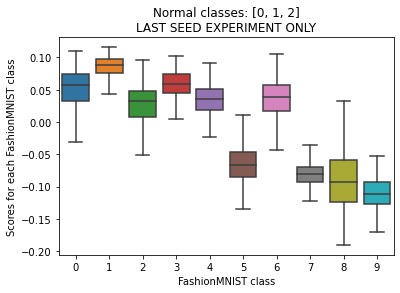

In [5]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = IsolationForest(random_state=seed_idx).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("IF-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))

100%|██████████| 3/3 [01:31<00:00, 30.36s/it]

MEAN VALID AUC +/- STD: 0.7892044186592102 +/- 0.003036376554518938
MEAN TEST AUC +/- STD: 0.7815338969230652 +/- 0.005380204878747463


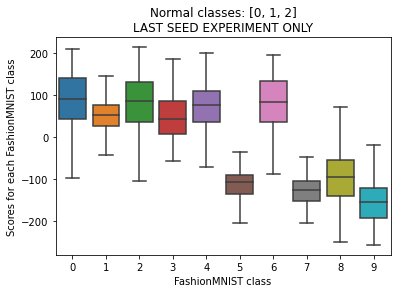

In [6]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = OneClassSVM(nu=0.1).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("OCSVM-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))

100%|██████████| 3/3 [00:29<00:00,  9.86s/it]

MEAN VALID AUC +/- STD: 0.865561306476593 +/- 0.0013079264899715781
MEAN TEST AUC +/- STD: 0.8641157150268555 +/- 0.0077929929830133915


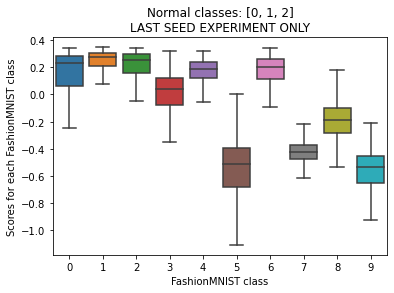

In [7]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = LocalOutlierFactor(n_neighbors=64, contamination=0.1, novelty=True).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("LOF-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))

# IF, OC-SVM and LOF with PCA dimensionality reduction

100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


MEAN VALID AUC +/- STD: 0.8462562561035156 +/- 0.006732582114636898
MEAN TEST AUC +/- STD: 0.8434601426124573 +/- 0.01108610164374113


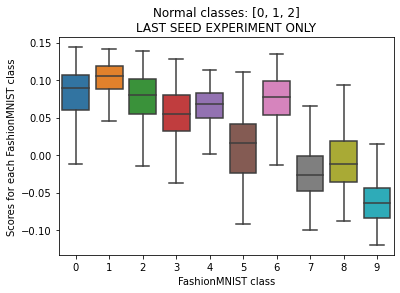

In [8]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    x_train = pca.fit_transform(x_train)
    x_valid = pca.transform(x_valid)
    x_test = pca.transform(x_test)
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = IsolationForest(random_state=seed_idx).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("IF-PCA-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))

100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

MEAN VALID AUC +/- STD: 0.782134473323822 +/- 0.004652039147913456
MEAN TEST AUC +/- STD: 0.7723626494407654 +/- 0.005159242078661919


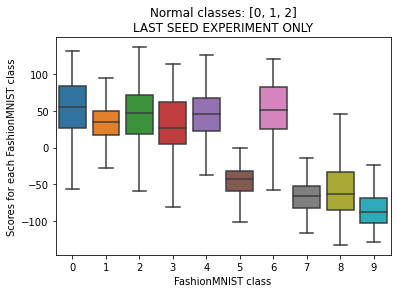

In [9]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    x_train = pca.fit_transform(x_train)
    x_valid = pca.transform(x_valid)
    x_test = pca.transform(x_test)
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = OneClassSVM(nu=0.1).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("OCSVM-PCA-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))

100%|██████████| 3/3 [00:21<00:00,  7.27s/it]

MEAN VALID AUC +/- STD: 0.8596253395080566 +/- 0.0031973335426300764
MEAN TEST AUC +/- STD: 0.8559381365776062 +/- 0.00891717430204153


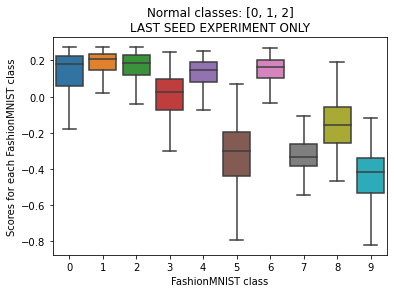

In [10]:
valid_AUCs = torch.zeros((nbr_seeds,))
test_AUCs = torch.zeros((nbr_seeds,))

for seed_idx in tqdm(range(nbr_seeds)):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    # 128 is batch_size, useless parameter here but we re-use the deep models import function for consistency
    _, _, _, x_train, y_train, x_valid, y_valid, x_test, y_test = get_dataloaders_MNIST_FashionMNIST(128, normal_cls, dataset, seed=seed_idx)
    
    x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
    x_valid = np.reshape(x_valid, (x_valid.shape[0], -1)) / 255
    x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255
    
    x_train = pca.fit_transform(x_train)
    x_valid = pca.transform(x_valid)
    x_test = pca.transform(x_test)
    
    y_valid_AD = convert_labels(y_valid, normal_cls)
    y_test_AD = convert_labels(y_test, normal_cls)
    
    clf = LocalOutlierFactor(n_neighbors=64, contamination=0.1, novelty=True).fit(x_train)
    y_score_val = clf.decision_function(x_valid)
    y_score_test = clf.decision_function(x_test)
    
    valid_AUCs[seed_idx] = roc_auc_score(y_valid_AD, y_score_val*-1)
    test_AUCs[seed_idx] = roc_auc_score(y_test_AD, y_score_test*-1)

print("MEAN VALID AUC +/- STD: {} +/- {}".format(torch.mean(valid_AUCs),torch.std(valid_AUCs)))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUCs),torch.std(test_AUCs)))

plt.figure()
boxplot(y=y_score_test, x=y_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Scores for each {} class'.format(dataset))
plt.title('Normal classes: {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls))

with open('last_results.txt', "a") as file:
    file.write("LOF-PCA-{}-Norm{}-{}seeds - MEAN TEST AUC +/- STD: {} +/- {}\n".format(dataset, normal_cls, nbr_seeds, torch.mean(test_AUCs),torch.std(test_AUCs)))